In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import welch, periodogram
import os
import matplotlib.dates as mdates
import utide
from oceans import bottomstress

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import statsmodels.api as sm
from statsmodels.formula.api import ols

from physoce import tseries as ts
from tseries import lombscargle
from scipy.stats import chi2

### Load data

#### Rover

In [2]:
# Load data
rover_csv_file = 'data/Rover_II_Current_Mag_Hourly_Avg_pad_2018.csv'
df_all = pd.read_csv(rover_csv_file,parse_dates=[7])

# Datetime index
df_all = df_all.set_index('Date_time_R')

# Create u and v components with units m/s
df_all['u'] = df_all['Easting (cm/sec)']/100
df_all['v'] = df_all['Northing (cm/sec)']/100

# mask erroneous points 
# abrupt shift near end of deployment 
bi = ((df_all.index > np.datetime64('2015-06-18T12:00')) &
    (df_all.index < np.datetime64('2015-06-20T00:00')))

df_all['u'][bi] = np.nan
df_all['v'][bi] = np.nan

# select time range
t1 = np.datetime64('2014-10-11T00:00:00')
t2 = np.datetime64('2018-10-17T00:00:00')
df_all = df_all.loc[(df_all.index >= t1) & (df_all.index <= t2)]

/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
# tidal analysis
time = mdates.date2num(df_all.index)

coef = utide.solve(time, np.array(df_all['u']), 
         np.array(df_all['v']),
         lat=35+8.4585/60,
         method='robust')

solve: matrix prep ... solution ... diagnostics ... done.


In [4]:
len(coef['name'])

68

In [5]:
coef['name']

array(['M2', 'S2', 'K1', 'O1', 'N2', 'MKS2', 'MSM', 'P1', 'K2', 'SA',
       'MF', 'MSF', 'H1', 'MS4', 'GAM2', 'M4', 'H2', 'SSA', 'MK3', 'Q1',
       'MM', 'T2', 'MSN2', 'R2', 'L2', 'NU2', 'MO3', 'SO3', 'LDA2', '2N2',
       'J1', 'S1', 'MN4', 'MU2', 'NO1', 'ETA2', 'OQ2', 'PI1', 'TAU1',
       'SN4', 'RHO1', '2Q1', 'OO1', 'S4', 'SIG1', 'EPS2', 'M3', 'PHI1',
       'THE1', '2MN6', 'CHI1', 'SO1', 'MK4', 'M6', 'ALP1', 'PSI1', '2SM6',
       'SK4', '2MK5', 'SK3', 'BET1', 'UPS1', '2SK5', 'MSK6', '2MK6', 'M8',
       '2MS6', '3MK7'], dtype=object)

In [6]:
crit = (coef['diagn']['SNR'] > 2) & (1/coef['aux']['frq'] < 48)

In [7]:
coef['name'][crit]

array(['M2', 'S2', 'K1', 'O1', 'N2', 'MKS2', 'P1', 'K2', 'H1', 'MS4',
       'GAM2', 'M4', 'H2', 'MK3', 'Q1', 'T2', 'MSN2', 'R2', 'L2', 'NU2',
       'MO3', 'SO3', 'LDA2', '2N2', 'J1', 'S1', 'MN4', 'MU2', 'NO1',
       'ETA2', 'OQ2', 'PI1', 'TAU1', 'SN4', 'RHO1', '2Q1', 'S4', 'SIG1',
       'EPS2', 'M3', 'PHI1', 'THE1', '2MN6', 'M6', '2SM6'], dtype=object)

In [8]:
1/coef['aux']['frq'] / 24

array([5.17525050e-01, 5.00000000e-01, 9.97269566e-01, 1.07580590e+00,
       5.27431176e-01, 5.16062594e-01, 3.18119415e+01, 1.00274543e+00,
       4.98634783e-01, 3.65259645e+02, 1.36607911e+01, 1.47652944e+01,
       5.18259356e-01, 2.54305803e-01, 5.18829165e-01, 2.58762525e-01,
       5.16792822e-01, 1.82621096e+02, 3.40714165e-01, 1.11951486e+00,
       2.75545497e+01, 5.00685383e-01, 4.91088789e-01, 4.99316491e-01,
       5.07984174e-01, 5.26083515e-01, 3.49429290e-01, 3.41351019e-01,
       5.09240590e-01, 5.37723936e-01, 9.62436529e-01, 9.99999869e-01,
       2.61215579e-01, 5.36323233e-01, 1.03471868e+00, 4.89771738e-01,
       5.48426416e-01, 1.00550584e+00, 1.06950553e+00, 2.56674699e-01,
       1.11346055e+00, 1.16692594e+00, 9.29419760e-01, 2.50000000e-01,
       1.16034948e+00, 5.46969476e-01, 3.45016700e-01, 9.91853188e-01,
       9.66956537e-01, 1.73595162e-01, 1.02954467e+00, 9.34174083e-01,
       2.53952166e-01, 1.72508350e-01, 1.21136110e+00, 9.94554132e-01,
      

In [9]:
# tide = utide.reconstruct(time,coef)

In [10]:
# df_all['u_tide'] = tide.u
# df_all['v_tide'] = tide.v
# df_all['u_detide'] = df_all['u'] - df_all['u_tide']
# df_all['v_detide'] = df_all['v'] - df_all['v_tide']

### Resample to hourly values

#### Define date range

In [11]:
# t1 = np.datetime64('2017-11-12T00:00:00')
# t2 = np.datetime64('2018-10-17T00:00:00')
# dff = dfr.loc[(dfr.index >= t1) & (dfr.index <= t2)].interpolate(limit=2)

In [12]:
# resample and interpolate
df_all_r = df_all.resample('1H').mean()

# Calculate tidal currents at hourly points
time_r = mdates.date2num(df_all_r.index)
#tide_r = utide.reconstruct(time_r,coef)
tide_r = utide.reconstruct(time_r,coef,constit=coef['name'][crit])
df_all_r['u_tide'] = tide_r.u
df_all_r['v_tide'] = tide_r.v
df_all_r['u_detide'] = df_all_r['u'] - df_all_r['u_tide']
df_all_r['v_detide'] = df_all_r['v'] - df_all_r['v_tide']

df_all_int = df_all_r.interpolate(limit=int(24*3.5))

df_all_int['u'] = df_all_int['u_detide'] + df_all_int['u_tide']
df_all_int['v'] = df_all_int['v_detide'] + df_all_int['v_tide']

df_all_int['u_f'] = ts.pl64(df_all_int['u_detide'])
df_all_int['v_f'] = ts.pl64(df_all_int['v_detide'])

df_all_int['u_super'] = df_all_int['u'] - df_all_int['u_f'] - df_all_int['u_tide']
df_all_int['v_super'] = df_all_int['v'] - df_all_int['v_f'] - df_all_int['v_tide']

prep/calcs ... done.


/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/scipy/signal/signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  in1zpadded[sc] = in1.copy()


### Subset with no gaps
November 2015-October 2018

In [13]:
# select time range
t1s = np.datetime64('2015-11-11T13:00:00')
t2s = np.datetime64('2018-10-14T07:00:00')
df_sub = df_all_int.loc[(df_all_int.index >= t1s) & (df_all_int.index <= t2s)]

### Initial plots

### Full velocity

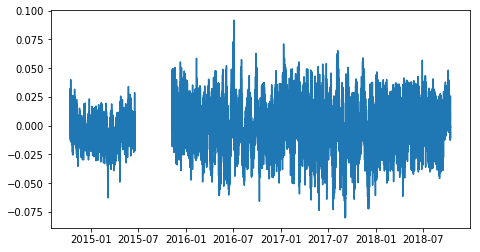

In [14]:
plt.figure(figsize=(7.5,4))
plt.plot(df_all.index,df_all['u'])

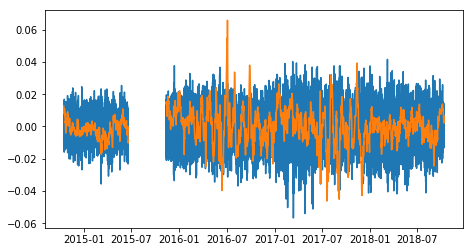

In [15]:
plt.figure(figsize=(7.5,4))
plt.plot(df_all_int.index,df_all_int['u_super'])
plt.plot(df_all_int.index,df_all_int['u_f'])

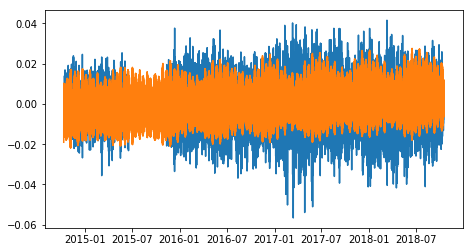

In [16]:
plt.figure(figsize=(7.5,4))
plt.plot(df_all_int.index,df_all_int['u_super'])
plt.plot(df_all_int.index,df_all_int['u_tide'])

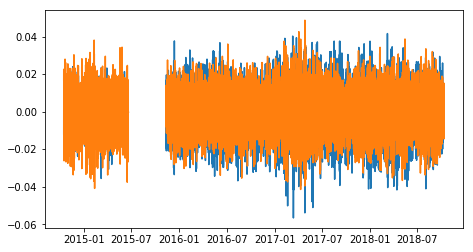

In [17]:
plt.figure(figsize=(7.5,4))
plt.plot(df_all_int.index,df_all_int['u_super'])
plt.plot(df_all_int.index,df_all_int['v_super'])

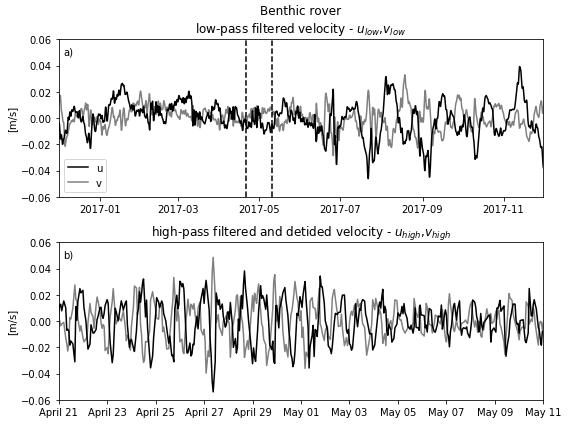

In [18]:
t1p = np.datetime64('2016-12-01')
t2p = np.datetime64('2017-12-01')

t1b = np.datetime64('2017-04-21')
t2b = np.datetime64('2017-05-11')

plt.figure(figsize=(8,6))
plt.subplot(211)
h1 = plt.plot(df_sub.index,df_sub['v_f'],'-',color='gray')
h2 = plt.plot(df_sub.index,df_sub['u_f'],'k-')
plt.ylim([-0.06,0.06])
plt.xlim([t1p,t2p])
yl = plt.ylim()
plt.plot([t1b,t1b],yl,'k--')
plt.plot([t2b,t2b],yl,'k--')
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'a)')
plt.ylabel('[m/s]')
plt.title('Benthic rover\nlow-pass filtered velocity - $u_{low}$,$v_{low}$')
plt.legend((h2[0],h1[0]),['u','v'],loc='lower left')

plt.subplot(212)
plt.plot(df_sub.index,df_sub['v_super'],color='gray')
plt.plot(df_sub.index,df_sub['u_super'],color='k')
plt.ylim([-0.06,0.06])
plt.xlim([t1b,t2b])
monthyearFmt = mdates.DateFormatter('%B %d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'b)')
plt.ylabel('[m/s]')
plt.title('high-pass filtered and detided velocity - $u_{high}$,$v_{high}$')
plt.tight_layout()

plt.savefig('figures_paper/rover_tseries_examples.png',dpi=600)
plt.savefig('figures_paper/rover_tseries_examples.pdf')

### Spectral analysis

In [19]:
u = np.array(df_sub['u'])
v = np.array(df_sub['v'])

N = len(u)
fu,Su = welch(u,fs=24.,nperseg=N/3,window='hanning')
fv,Sv = welch(v,fs=24.,nperseg=N/3,window='hanning')

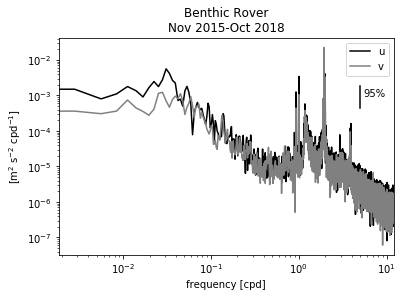

In [20]:
# fmax = 1/2
# fi, = np.where(fu <= fmax)

plt.figure()
plt.loglog(fu,Su,'k-')
plt.loglog(fv,Sv,'-',color='gray')
xl = plt.xlim()
plt.xlim(xl[0],np.max(fu))

# confidence intervals
dof = 6
edof = (8/3)*dof
lower = edof/chi2.ppf(0.975,edof)
upper = edof/chi2.ppf(0.025,edof)
fplot = 5
fac = 0.0008
plt.plot(np.array([fplot,fplot]),fac*np.array([lower,upper]),'k-')
plt.text(fplot+0.5,fac*np.mean([lower,upper]),'95%',verticalalignment='center')

plt.legend(['u','v'])
plt.xlabel('frequency [cpd]')
plt.ylabel('[m$^2$ s$^{-2}$ cpd$^{-1}$]')
plt.title('Benthic Rover\nNov 2015-Oct 2018')

plt.savefig('figures_paper/rover_spectrum.png')
plt.savefig('figures_paper/rover_spectrum.pdf')

### Lomb-Scargle periodogram - 2014 to 2018

In [21]:
gi, = np.where(np.isfinite(df_all['u']+df_all['v']))
ua = np.array(df_all['u'][gi])
va = np.array(df_all['v'][gi])

#rotary spectrum
fua,ftua,Sua = lombscargle(time[gi],ua,ofac=1,window='hanning',scaling='density')
fva,ftva,Sva = lombscargle(time[gi],va,ofac=1,window='hanning',scaling='density')

In [22]:
# average frequency bands
navg = 2 # number of frequency bands to average
nfreq = int(np.floor(len(fua)/navg))  # number of freqencies in averaged spectrum

fwt = 1/navg
fm = np.zeros(nfreq)
Sum = np.zeros(nfreq)
Svm = np.zeros(nfreq)
for k in range(navg):
    fm = fm + fwt*fua[1:(nfreq*navg)][::navg]
    Sum = Sum + fwt*Sua[1:(nfreq*navg)][::navg]
    Svm = Svm + fwt*Sva[1:(nfreq*navg)][::navg]

In [23]:
Sum

array([3.49997163e-04, 2.22530111e-03, 1.92575183e-03, ...,
       4.81409249e-06, 1.48315243e-07, 2.90089730e-07])

Text(0.5, 1.0, 'Lomb-Scargle periodogram [Rover]')

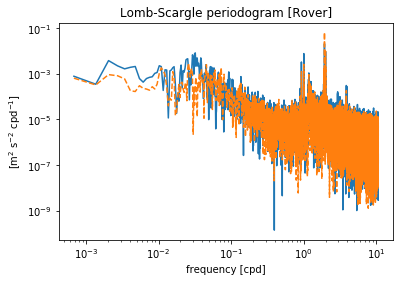

In [24]:
plt.figure()
plt.loglog(fua,Sua)
plt.loglog(fva,Sva,'--')
plt.xlabel('frequency [cpd]')
plt.ylabel('[m$^2$ s$^{-2}$ cpd$^{-1}$]')
plt.title('Lomb-Scargle periodogram [Rover]')

In [25]:
df_all_1M = df_all_int.rolling(24*30,min_periods=24*30,center=True).mean()
df_all_2M = df_all_int.rolling(24*60,min_periods=24*60,center=True).mean()
df_all_3M = df_all_int.rolling(24*90,min_periods=24*90,center=True).mean()

In [26]:
df_all_3M_mon = df_all_3M.resample('1M').last()
df_all_2M_mon = df_all_2M.resample('1M').last()
df_all_1M_mon = df_all_1M.resample('1M').last()

In [27]:
df_all_1Mstd = df_all_int.rolling(24*30,min_periods=24*30,center=True).std()
df_all_2Mstd = df_all_int.rolling(24*60,min_periods=24*60,center=True).std()
df_all_3Mstd = df_all_int.rolling(24*90,min_periods=24*90,center=True).std()

In [28]:
df_all_3Mstd_mon = df_all_3Mstd.resample('1M').last()
df_all_2Mstd_mon = df_all_2Mstd.resample('1M').last()
df_all_1Mstd_mon = df_all_1Mstd.resample('1M').last()

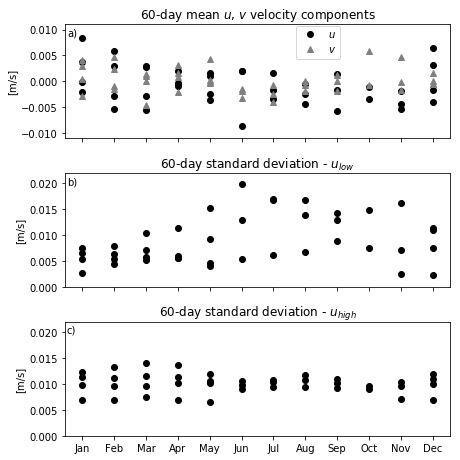

In [29]:
plt.figure(figsize=(6.5,6.5))
plt.subplot(311)
plt.plot(df_all_2M_mon.index.month,df_all_2M_mon['u_f'],'ko')
plt.plot(df_all_2M_mon.index.month,df_all_2M_mon['v_f'],'^',color='gray')
plt.ylim([-0.011,0.011])
plt.ylabel('[m/s]')
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.005*np.diff(xl),yl[1]-0.1*np.diff(yl),'a)')
plt.gca().set_xticks(np.arange(1,13))
plt.gca().set_xticklabels([])
plt.legend(['$u$','$v$'],loc=(0.6,0.7))
plt.title('60-day mean $u$, $v$ velocity components')

plt.subplot(312)
plt.plot(df_all_2Mstd_mon.index.month,df_all_2Mstd_mon['u_f'],'ko')
plt.ylim([0,0.022])
plt.ylabel('[m/s]')
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.005*np.diff(xl),yl[1]-0.1*np.diff(yl),'b)')
plt.gca().set_xticks(np.arange(1,13))
plt.gca().set_xticklabels([])
plt.title('60-day standard deviation - $u_{low}$')

plt.subplot(313)
plt.plot(df_all_2Mstd_mon.index.month,df_all_2Mstd_mon['u_super'],'ko')
plt.ylim([0,0.022])
plt.ylabel('[m/s]')
xl = plt.xlim()
yl = plt.ylim()
plt.text(xl[0]+0.005*np.diff(xl),yl[1]-0.1*np.diff(yl),'c)')
plt.gca().set_xticks(np.arange(1,13))
plt.gca().set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('60-day standard deviation - $u_{high}$')
plt.tight_layout()

plt.savefig('figures_paper/monthly_stats.png',dpi=600)
plt.savefig('figures_paper/monthly_stats.pdf')

In [30]:
fi = np.isfinite(df_all_2Mstd_mon['u_f'])

In [31]:
MultiComp = MultiComparison(df_all_2Mstd_mon['u_f'][fi],
                            df_all_2Mstd_mon.index.month[fi])

In [32]:
df_all_2Mstd_mon

,Unnamed: 0,Current_mag,Easting (cm/sec),Northing (cm/sec),Minutes,Seconds,u,v,u_tide,v_tide,u_detide,v_detide,u_f,v_f,u_super,v_super
Date_time_R,,,,,,,,,,,,,,,,
2014-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30,415.871014,0.934629,0.730026,1.621102,7.479623,11.140831,0.007375,0.016459,0.007751,0.011642,0.007599,0.009803,0.002597,0.003466,0.007070,0.009094
2014-12-31,415.837064,0.964297,0.757248,1.676798,7.592627,10.946328,0.007603,0.017002,0.007281,0.012023,0.007396,0.010335,0.002291,0.003088,0.006970,0.009778
2015-01-31,415.837176,1.034222,0.796061,1.806495,7.672934,10.932526,0.008013,0.018322,0.006970,0.011980,0.007503,0.011474,0.002681,0.002793,0.006952,0.011011
2015-02-28,415.420054,0.988327,0.854650,1.585933,7.502846,11.163207,0.008630,0.016109,0.007008,0.011828,0.008337,0.011297,0.004456,0.005057,0.006982,0.009975
2015-03-31,415.679270,0.987474,0.930683,1.500098,7.685077,10.961499,0.009401,0.015264,0.007420,0.011909,0.009473,0.010983,0.005863,0.006254,0.007398,0.008892
2015-04-30,415.831987,0.959486,0.928179,1.687715,7.840095,10.860610,0.009385,0.017137,0.007693,0.012184,0.008907,0.011564,0.005524,0.007032,0.006920,0.009076
2015-05-31,415.782746,2.561590,1.928168,2.236844,7.966458,10.519992,0.009039,0.016774,0.007642,0.012418,0.007822,0.010695,0.004147,0.005817,0.006542,0.009098
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007427,0.012350,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_all_2Mstd_mon.index.month[fi]

Int64Index([11, 12,  1,  2,  3,  4,  5, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
             3,  4,  5,  6,  7,  8,  9],
           dtype='int64', name='Date_time_R')

In [34]:
print(MultiComp.tukeyhsd(0.05).summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.0005  -0.0106 0.0115 False 
  1      3     0.0016  -0.0095 0.0127 False 
  1      4     0.0016  -0.0095 0.0127 False 
  1      5     0.0028  -0.0083 0.0139 False 
  1      6     0.0072  -0.0048 0.0192 False 
  1      7     0.0077  -0.0042 0.0197 False 
  1      8     0.007    -0.005 0.019  False 
  1      9     0.0065  -0.0055 0.0184 False 
  1      10    0.0056  -0.0079 0.0192 False 
  1      11    0.0031  -0.0089 0.0151 False 
  1      12    0.0025  -0.0086 0.0136 False 
  2      3     0.0012  -0.0099 0.0122 False 
  2      4     0.0011   -0.01  0.0122 False 
  2      5     0.0023  -0.0087 0.0134 False 
  2      6     0.0067  -0.0052 0.0187 False 
  2      7     0.0073  -0.0047 0.0192 False 
  2      8     0.0065  -0.0054 0.0185 False 
  2      9     0.006    -0.006 0.018  False 
  2      10    0.0052  -0.0084 0.0188 False 
  2 

In [35]:
MultiComp_std = MultiComparison(df_all_2Mstd_mon['u_f'][fi],
                            df_all_2Mstd_mon.index.month[fi])

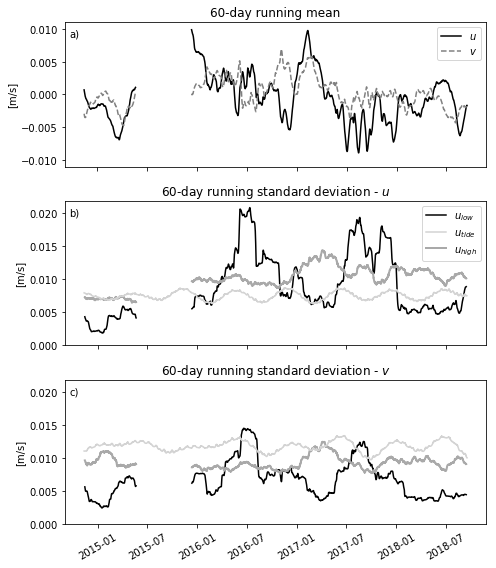

In [36]:
plt.figure(figsize=(7,8))
plt.subplot(311)
plt.plot(df_all_2M.index,df_all_2M['u_f'],'k-')
plt.plot(df_all_2M.index,df_all_2M['v_f'],'--',color='gray')
plt.title('60-day running mean')
plt.ylim([-0.011,0.011])
plt.ylabel('[m/s]')
plt.gca().set_xticklabels([])
yl = plt.ylim()
xl = plt.xlim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'a)')
plt.legend(['$u$','$v$'])

plt.subplot(312)
hl = plt.plot(df_all_2Mstd.index,df_all_2Mstd['u_f'],'k-')
hh = plt.plot(df_all_2Mstd.index,df_all_2Mstd['u_super'],'-',color='darkgray',lw=2)
ht = plt.plot(df_all_2Mstd.index,df_all_2Mstd['u_tide'],'-',color='lightgray')
plt.gca().set_xticklabels([])
yl = plt.ylim()
plt.ylim([0,yl[1]])
plt.ylabel('[m/s]')
plt.title('60-day running standard deviation - $u$')
yl = plt.ylim()
xl = plt.xlim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'b)')
plt.legend([hl[0],ht[0],hh[0]],['$u_{low}$','$u_{tide}$','$u_{high}$'])

plt.subplot(313)
plt.plot(df_all_2Mstd.index,df_all_2Mstd['v_f'],'k-')
plt.plot(df_all_2Mstd.index,df_all_2Mstd['v_super'],'-',color='darkgray',lw=2)
plt.plot(df_all_2Mstd.index,df_all_2Mstd['v_tide'],'-',color='lightgray')
plt.xticks(rotation=30)
plt.ylim([0,yl[1]])
plt.title('60-day running standard deviation - $v$')
plt.ylabel('[m/s]')
plt.tight_layout()
yl = plt.ylim()
xl = plt.xlim()
plt.text(xl[0]+0.01*np.diff(xl),yl[1]-0.1*np.diff(yl),'c)')

plt.savefig('figures_paper/runnning_stats.png',dpi=600)
plt.savefig('figures_paper/runnning_stats.pdf')

Text(0.5, 1.0, 'rolling means')

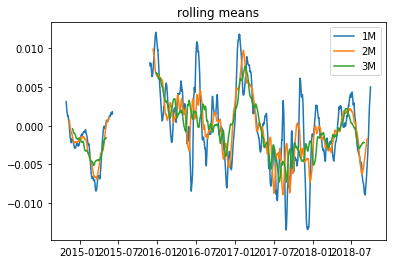

In [37]:
plt.figure()
plt.plot(df_all_1M.index,df_all_1M['u_f'])
plt.plot(df_all_2M.index,df_all_2M['u_f'])
plt.plot(df_all_3M.index,df_all_3M['u_f'])
plt.legend(['1M','2M','3M'])
plt.title('rolling means')

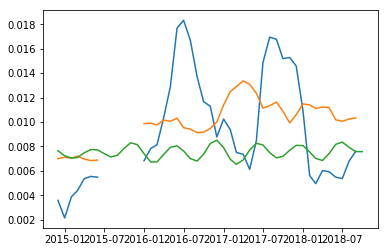

In [38]:
plt.figure()
plt.plot(df_all_3Mstd_mon.index,df_all_3Mstd_mon['u_f'])
plt.plot(df_all_3Mstd_mon.index,df_all_3Mstd_mon['u_super'])
plt.plot(df_all_3Mstd_mon.index,df_all_3Mstd_mon['u_tide'])

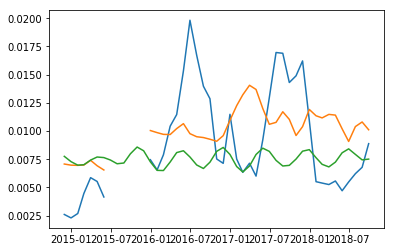

In [39]:
plt.figure()
plt.plot(df_all_2Mstd_mon.index,df_all_2Mstd_mon['u_f'])
plt.plot(df_all_2Mstd_mon.index,df_all_2Mstd_mon['u_super'])
plt.plot(df_all_2Mstd_mon.index,df_all_2Mstd_mon['u_tide'])

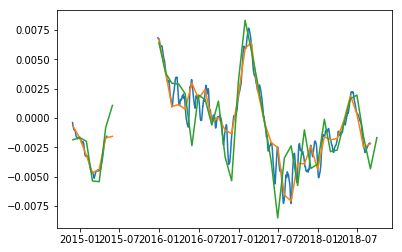

In [40]:
plt.figure()
plt.plot(df_all_3M.index,df_all_3M['u_f'])
plt.plot(df_all_3M_mon.index,df_all_3M_mon['u_f'])
plt.plot(df_all_2M_mon.index,df_all_2M_mon['u_f'])

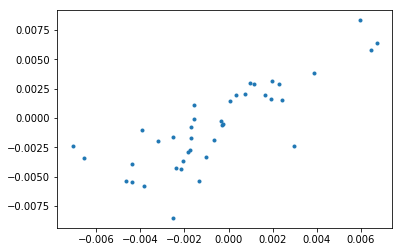

In [41]:
plt.figure()
plt.plot(df_all_3M_mon['u_f'],df_all_2M_mon['u_f'],'.')

Text(0.5, 1.0, 'rolling means')

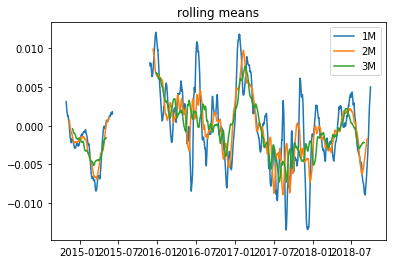

In [42]:
plt.figure()
plt.plot(df_all_1M.index,df_all_1M['u_f'])
plt.plot(df_all_2M.index,df_all_2M['u_f'])
plt.plot(df_all_3M.index,df_all_3M['u_f'])
plt.legend(['1M','2M','3M'])
plt.title('rolling means')

In [43]:
taux,tauy = bottomstress(np.array(df_all['u']),np.array(df_all['v']),1.4,zo=0.03)

In [44]:
taumag = np.sqrt(taux**2 + tauy**2)

In [45]:
ustar = np.sqrt(taumag/1025)

In [46]:
tim, = np.where(ustar == np.nanmax(ustar))

In [47]:
df_all.index[tim]

DatetimeIndex(['2017-05-27 23:00:00'], dtype='datetime64[ns]', name='Date_time_R', freq=None)

In [48]:
np.nanmean(ustar)

0.00218073094015227

In [49]:
np.nanmax(ustar)

0.010466122007886648